# Comparison between triaxial ellipsoid and sphere

### Import the required modules and functions

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from fatiando import mesher, gridder, utils
from fatiando.gravmag import triaxial_ellipsoid, sphere

C:\Users\Vanderlei\Documents\fatiando\fatiando\vis\mpl.py:76: UserWarning: This module will be removed in v0.6. We recommend the use of matplotlib.pyplot module directly. Some of the fatiando specific functions will remain.
  "specific functions will remain.")


In [2]:
# Set some plot parameters
from matplotlib import rcParams
rcParams['figure.dpi'] = 300.
rcParams['font.size'] = 6
rcParams['xtick.labelsize'] = 'medium'
rcParams['ytick.labelsize'] = 'medium'
rcParams['axes.labelsize'] = 'large'
rcParams['legend.fontsize'] = 'medium'
rcParams['savefig.dpi'] = 300.

### Set some parameters for modelling

In [3]:
# The local-geomagnetic field
F, inc, dec = 60000., 50., 20.

# boundaries of the study area
bounds = [-5000, 5000, -4000, 6000, 0, 5000]

# Create a regular grid at z = 0 m
shape = (200, 200)
area = bounds[:4]
xp, yp, zp = gridder.regular(area, shape, z=0)

### Triaxial ellipsoid versus sphere

This test compares the total-field anomalies produced by a triaxial ellipsoid with that produced by a sphere. The ellipsoid has semi-axes $a$, $b$, and $c$ equal to `501 m`, `500 m`, and `499 m`, respectively, and the sphere has a radius equal to the intermediate semi-axis $b$. Both bodies are centered at the point `(0, 1000, 1100)` and have the same magnetization.

##### Triaxial ellipsoid

In [4]:
ellipsoid = mesher.TriaxialEllipsoid(0, 1000, 1100,
                                     501, 500, 499,
                                     180*np.random.rand(), -90 + 180*np.random.rand(), 90*np.random.rand(),
                                     {'remanence': [5, 25, 40],
                                      'k': [0.01, 0.01, 0.01, 0, 90, 90]})

In [5]:
# magnetization

n11, n22, n33 = triaxial_ellipsoid.demag_factors(ellipsoid.a,
                                                 ellipsoid.b,
                                                 ellipsoid.c)
k1, k2, k3, alphak, gammak, deltak = ellipsoid.props['k']
K = triaxial_ellipsoid.K(k1, k2, k3, alphak, gammak, deltak)
Mr, incr, decr = ellipsoid.props['remanence']
V = triaxial_ellipsoid.V(ellipsoid.alpha,
                         ellipsoid.gamma,
                         ellipsoid.delta)

In [6]:
magnetization = triaxial_ellipsoid.magnetization(n11, n22, n33, K,
                                                 F, inc, dec,
                                                 Mr, incr, decr, V)

##### Sphere

In [7]:
spherical_body = mesher.Sphere(ellipsoid.x, ellipsoid.y, ellipsoid.z,
                               ellipsoid.b, {'magnetization': np.dot(V, magnetization)})

##### Total-field anomalies

In [8]:
# total-field anomaly produced by the ellipsoid (in nT)
tf_t = triaxial_ellipsoid.tf(xp, yp, zp, [ellipsoid],
                             F, inc, dec)

# total-field anomaly produced by the sphere (in nT)
tf_s = sphere.tf(xp, yp, zp, [spherical_body], inc, dec)

# residuals
tf_r = tf_t - tf_s

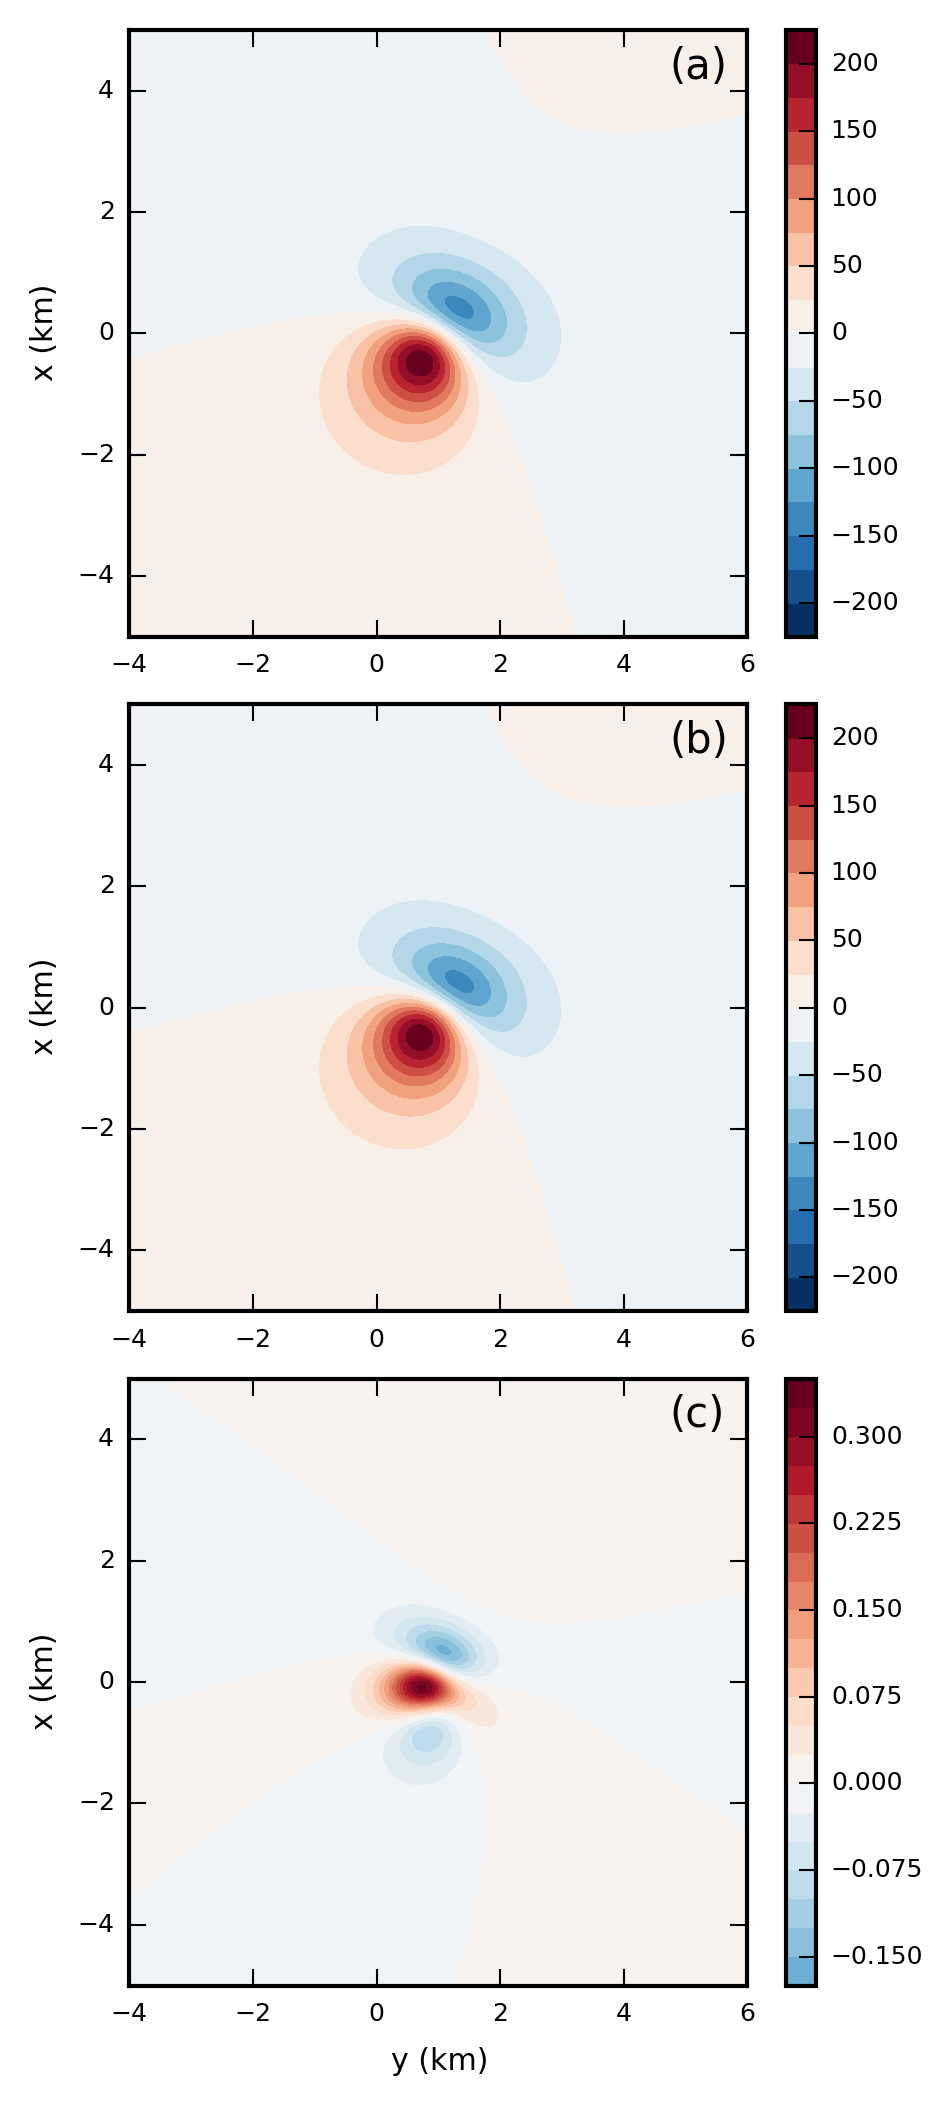

In [29]:
plt.figure(figsize=(3.15, 7))
plt.axis('scaled')

ranges = np.max(np.abs([np.min(tf_t), np.max(tf_t),
                        np.min(tf_s), np.max(tf_s)]))
levels = MaxNLocator(nbins=20).tick_values(-ranges, ranges)
cmap = plt.get_cmap('RdBu_r')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

plt.subplot(3,1,1)
plt.contourf(0.001*yp.reshape(shape), 0.001*xp.reshape(shape),
             tf_t.reshape(shape), levels=levels,
             cmap = cmap, norm=norm)
plt.ylabel('x (km)')
plt.xlim(0.001*np.min(yp), 0.001*np.max(yp))
plt.ylim(0.001*np.min(xp), 0.001*np.max(xp))
cbar = plt.colorbar()
plt.annotate(s='(a)', xy=(0.88,0.92),
             xycoords = 'axes fraction', color='k',
             fontsize = 10)

plt.subplot(3,1,2)
plt.contourf(0.001*yp.reshape(shape), 0.001*xp.reshape(shape),
             tf_s.reshape(shape), levels=levels,
             cmap = cmap, norm=norm)
plt.ylabel('x (km)')
plt.xlim(0.001*np.min(yp), 0.001*np.max(yp))
plt.ylim(0.001*np.min(xp), 0.001*np.max(xp))
plt.colorbar()
plt.annotate(s='(b)', xy=(0.88,0.92),
             xycoords = 'axes fraction', color='k',
             fontsize = 10)

ranges = np.max(np.abs([np.min(tf_r), np.max(tf_r)]))
plt.subplot(3,1,3)
plt.contourf(0.001*yp.reshape(shape), 0.001*xp.reshape(shape),
             tf_r.reshape(shape), 20, cmap = cmap, 
             vmin = -ranges, vmax = ranges)
plt.ylabel('x (km)')
plt.xlabel('y (km)')
plt.xlim(0.001*np.min(yp), 0.001*np.max(yp))
plt.ylim(0.001*np.min(xp), 0.001*np.max(xp))
plt.colorbar()
plt.annotate(s='(c)', xy=(0.88,0.92), 
             xycoords = 'axes fraction', color='k',
             fontsize = 10)

plt.tight_layout()
plt.savefig('..\\manuscript\\figures\\fields_triaxial_sphere.pdf', facecolor='w', bbox_inches='tight')

plt.show()

##### Field components

In [9]:
# field components produced by the ellipsoid (in nT)
bx_t = triaxial_ellipsoid.bx(xp, yp, zp, [ellipsoid],
                             F, inc, dec)
by_t = triaxial_ellipsoid.by(xp, yp, zp, [ellipsoid],
                             F, inc, dec)
bz_t = triaxial_ellipsoid.bz(xp, yp, zp, [ellipsoid],
                             F, inc, dec)

bt = [bx_t, by_t, bz_t]

# field components produced by the sphere (in nT)
bx_s = sphere.bx(xp, yp, zp, [spherical_body])
by_s = sphere.by(xp, yp, zp, [spherical_body])
bz_s = sphere.bz(xp, yp, zp, [spherical_body])

bs = [bx_s, by_s, bz_s]

# residuals
bx_r = bx_t - bx_s
by_r = by_t - by_s
bz_r = bz_t - bz_s

br = [bx_r, by_r, bz_r]

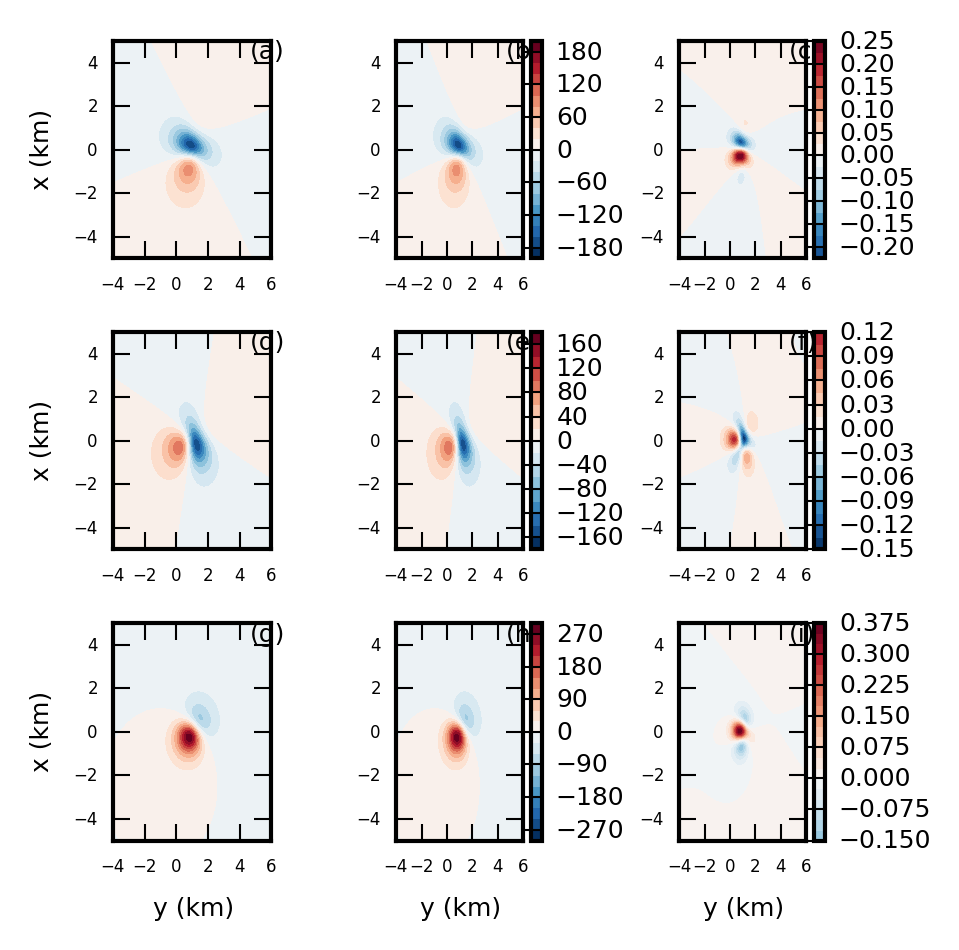

In [16]:
labels = ['(a)', '(b)', '(c)',
          '(d)', '(e)', '(f)',
          '(g)', '(h)', '(i)']

fontsize_annotate = 6
position_annotate = (0.88,0.92)
fontsize_ticks = 4
labelsize_axes = 6

plt.figure(figsize=(3.15, 3.15))
plt.axis('equal')

for i in range(3):

    ranges = np.max(np.abs([np.min(bt[i]), np.max(bt[i]),
                            np.min(bs[i]), np.max(bs[i])]))
    levels = MaxNLocator(nbins=20).tick_values(-ranges, ranges)
    cmap = plt.get_cmap('RdBu_r')
    norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

    plt.subplot(3,3,3*i + 1)
    plt.contourf(0.001*yp.reshape(shape), 0.001*xp.reshape(shape),
                 bt[i].reshape(shape), levels=levels,
                 cmap = cmap, norm=norm)
    plt.ylabel('x (km)', fontsize = labelsize_axes)
    if i == 2:
        plt.xlabel('y (km)', fontsize = labelsize_axes)
    plt.xticks(fontsize = fontsize_ticks)
    plt.yticks(fontsize = fontsize_ticks)
    plt.xlim(0.001*np.min(yp), 0.001*np.max(yp))
    plt.ylim(0.001*np.min(xp), 0.001*np.max(xp))
    plt.annotate(s=labels[3*i], xy=position_annotate, 
                  xycoords = 'axes fraction', color='k',
                  fontsize=fontsize_annotate)

    plt.subplot(3,3,3*i + 2)
    plt.contourf(0.001*yp.reshape(shape), 0.001*xp.reshape(shape),
                 bs[i].reshape(shape), levels=levels,
                 cmap = cmap, norm=norm)
    if i == 2:
        plt.xlabel('y (km)', fontsize = labelsize_axes)
    plt.xticks(fontsize = fontsize_ticks)
    plt.yticks(fontsize = fontsize_ticks)
    plt.xlim(0.001*np.min(yp), 0.001*np.max(yp))
    plt.ylim(0.001*np.min(xp), 0.001*np.max(xp))
    plt.colorbar()
    plt.annotate(s=labels[3*i + 1], xy=position_annotate, 
                  xycoords = 'axes fraction', color='k',
                  fontsize=fontsize_annotate)

    ranges = np.max(np.abs([np.min(br[i]), np.max(br[i])]))
    plt.subplot(3,3,3*i + 3)
    plt.contourf(0.001*yp.reshape(shape), 0.001*xp.reshape(shape),
                 br[i].reshape(shape), 20, cmap = cmap, 
                 vmin = -ranges, vmax = ranges)
    if i == 2:
        plt.xlabel('y (km)', fontsize = labelsize_axes)
    plt.xticks(fontsize = fontsize_ticks)
    plt.yticks(fontsize = fontsize_ticks)
    plt.xlim(0.001*np.min(yp), 0.001*np.max(yp))
    plt.ylim(0.001*np.min(xp), 0.001*np.max(xp))
    plt.colorbar()
    plt.annotate(s=labels[3*i + 2], xy=position_annotate, 
                 xycoords = 'axes fraction', color='k',
                 fontsize = fontsize_annotate)

plt.tight_layout()
#plt.savefig('..\\manuscript\\figures\\fields_triaxial_sphere.pdf', facecolor='w', bbox_inches='tight')

plt.show()

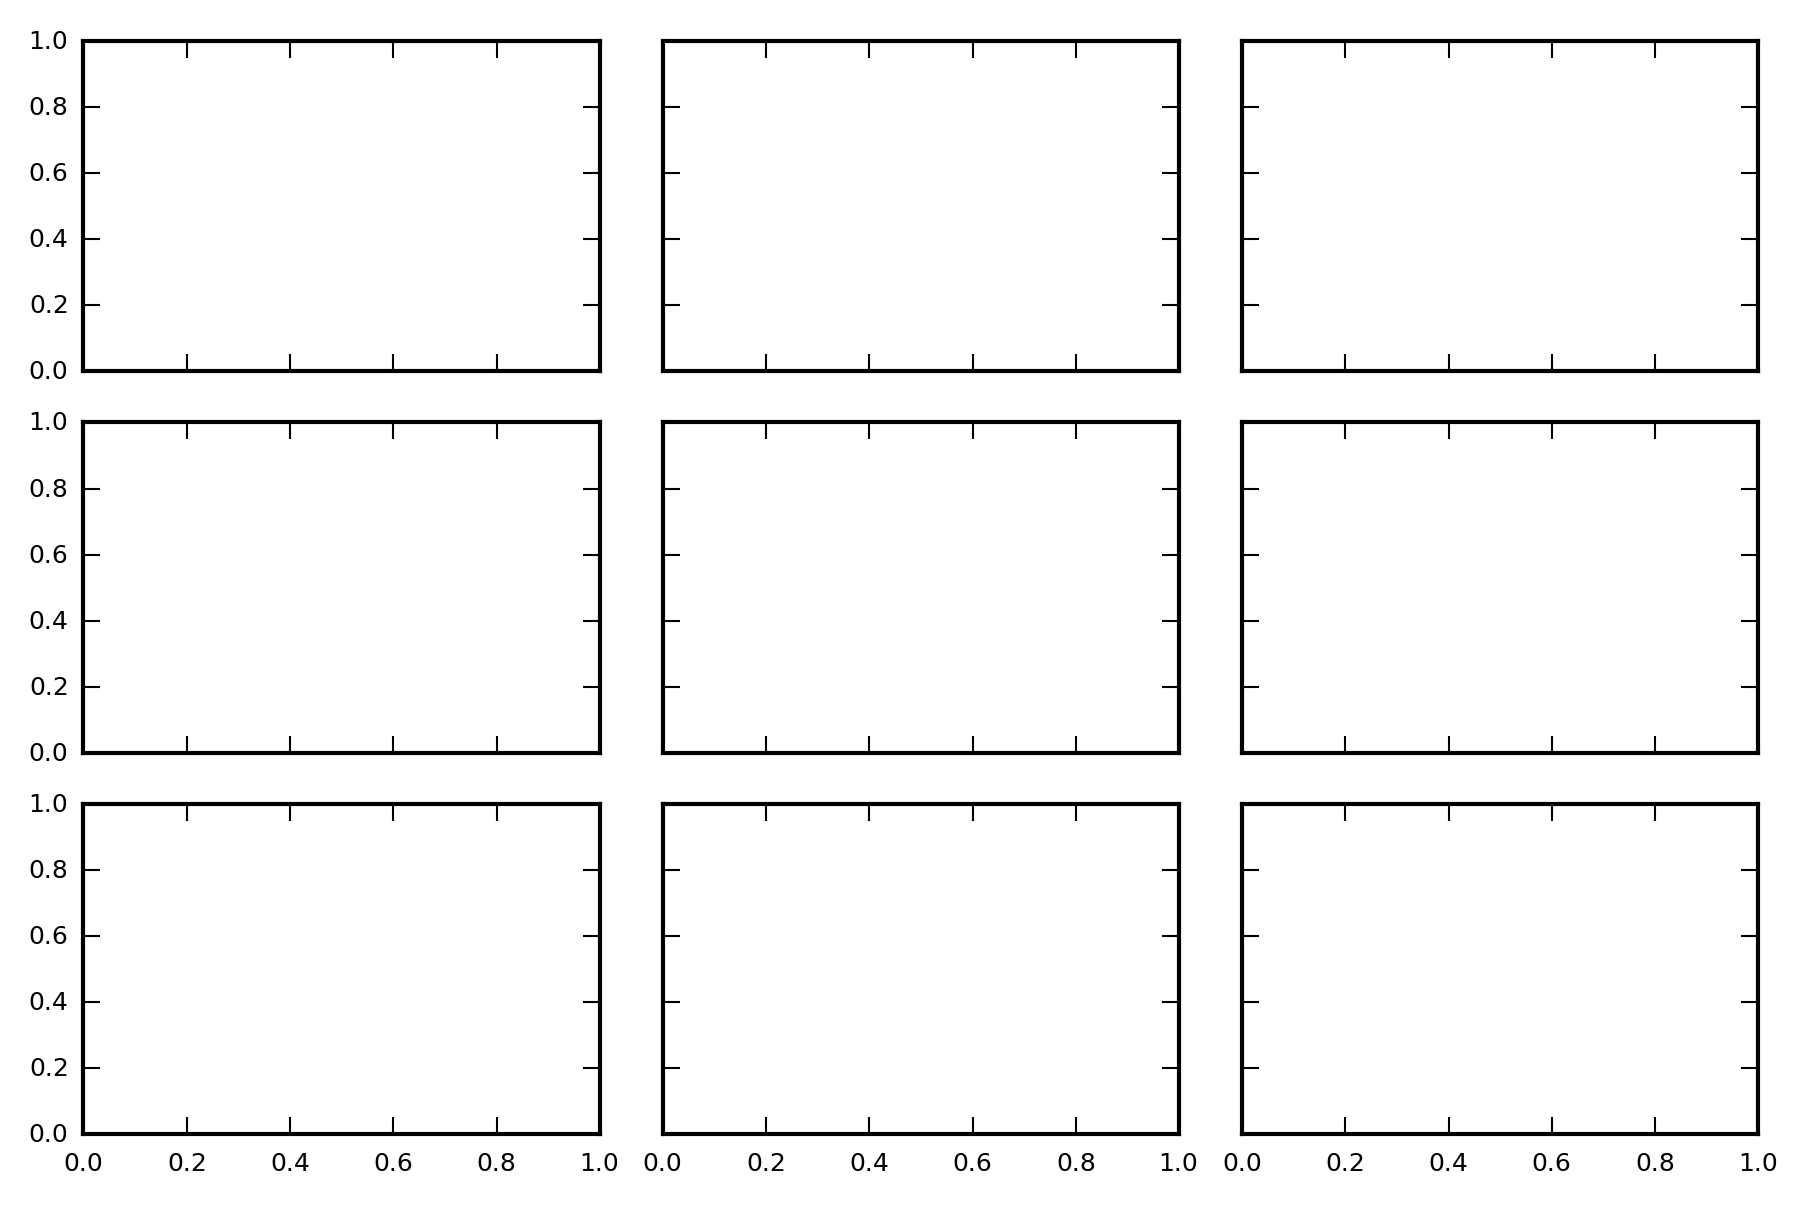

In [28]:
fig, axes = plt.subplots(nrows=3, ncols=3, sharex = True, sharey = True)

for i in range(2):
    for j in range(3):
        plt.setp(axes[i,j].get_xticklabels(), visible=False)
        
for i in range(3):
    for j in range(1,3):
        plt.setp(axes[i,j].get_yticklabels(), visible=False)



fig.tight_layout()

plt.show()